# Pix2Pix Image Translation: SAR to RGB


The Pix2Pix model is an architecture designed for image-to-image translation tasks, such as converting sketches to photos or colorizing black-and-white images. The Pix2Pix architecture uses two main components:

1. Generator: The generator network creates fake images from input data, using an U-Net like architecture.

2. Discriminator: The discriminator distinguishes between real and fake images. The goal of the discriminator is to classify whether a given image is real or fake. In Pix2Pix, a 70x70 PatchGAN is often used, where the discriminator processes image patches rather than the full image.

The model is trained using adversarial loss and a reconstruction loss (L1 loss) to encourage the generator to produce high-quality images that are close to the ground truth.


## Import Libraries

In [1]:
import json
import random
from pathlib import Path
from enum import Enum
from typing import Tuple, List, Optional, Callable, Union, Literal

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from tqdm import tqdm
from torchinfo import summary
from torchvision import models
from scipy.linalg import sqrtm

## Prepare The Dataset

In [ ]:
class SplitType(Enum):
    """Enumeration for dataset split types"""
    TRAIN = 'train'
    VAL = 'val'
    TEST = 'test'


class Sentinel(Dataset):
  
    def __init__(self,
                 root_dir: Union[str, Path],
                 split_type: Optional[str] = None,
                 transform: Optional[Callable] = None,
                 split_mode: Literal['random', 'split'] = 'random',
                 split_ratio: Tuple[float, float, float] = (0.7, 0.15, 0.15),
                 split_file: Optional[Union[str, Path]] = None,
                 seed: int = 42):
        self.root_dir = Path(root_dir)
        if not self.root_dir.exists():
            raise FileNotFoundError(f"Dataset root directory not found: {self.root_dir}")
        
        # Convert string split_type to enum if provided
        self.split_type = SplitType(split_type) if split_type else None

        # Default transform pipeline
        self.transform = transform if transform else v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True)
        ])

        # Collect image pairs
        self.all_image_pairs = self._collect_images()

        # Apply split if specified
        if split_type:
            if split_mode == 'split' and split_file:
                self.image_pairs = self._apply_predefined_split(split_file)
            elif split_mode == 'random':
                self.image_pairs = self._apply_random_split(split_ratio, seed)
            else:
                raise ValueError("Invalid split configuration. Use either 'split' with a split_file or 'random' with split_ratio")
        else:
            # If no split type specified, use all images
            self.image_pairs = self.all_image_pairs

        print(f'Total image pairs found: {len(self)}')

    def _collect_images(self) -> List[Tuple[Path, Path]]:
        """
        Collects paired SAR (s1) and optical (s2) image paths from the dataset directory.
            
        Returns:
            List[Tuple[Path, Path]]: List of (SAR image path, optical image path) pairs
        """
        image_pairs = []
        
        # Iterate through category subdirectories
        for category in self.root_dir.iterdir():
            # Check if it's a directory
            if not category.is_dir():
                continue

            s1_path = category / 's1'
            s2_path = category / 's2'
            
            if not (s1_path.is_dir() and s2_path.is_dir()):
                # print(f"Missing s1 or s2 subdirectory in category: {category.name}")
                continue

            # Collect pairs
            for s1_file in s1_path.glob('*.png'):
                # Convert SAR filename to optical filename
                # e.g. 'ROIs1970_fall_s1_13_p265.png' -> 'ROIs1970_fall_s2_13_p265.png'
                s2_filename = list(s1_file.name.split('_'))
                s2_filename[2] = 's2'
                s2_file = s2_path / '_'.join(s2_filename)

                if not s2_file.exists():
                    # print(f"Missing optical image for SAR image: {s1_file.name} - {s2_file.name}")
                    continue

                image_pairs.append((s1_file, s2_file))
        
        return image_pairs
    
    def _apply_predefined_split(self, split_file: Union[str, Path]) -> List[Tuple[Path, Path]]:
        """
        Applies a predefined split from a JSON file.
        
        Args:
            split_file: Path to JSON file containing split definitions
            
        Returns:
            List[Tuple[Path, Path]]: Image pairs for the specified split
        """
        try:
            with open(split_file, 'r') as f: # get the split content
                splits = json.load(f)
                
            if self.split_type.value not in splits['data']: # check if it helds
                raise ValueError(f"Split type {self.split_type.value} not found in split file")
            
            split_filenames = set(splits['data'][self.split_type.value]) # data['split']
            return [pair for pair in self.all_image_pairs # collect and return split
                if any(str(p.relative_to(self.root_dir)) in split_filenames for p in pair[:2])]
        except Exception as e:
            print(f'Could not open split file\n\t{e}')
            raise

    def _apply_random_split(
        self, 
        split_ratio: Tuple[float, float, float],
        seed: int
    ) -> List[Tuple[Path, Path]]:
        """
        Randomly splits the dataset according to the given ratios.
        
        Args:
            split_ratio: Tuple of (train, val, test) ratios
            seed: Random seed for reproducibility
            
        Returns:
            List[Tuple[Path, Path]]: Image pairs for the specified split
        """
        if sum(split_ratio) != 1:
            raise ValueError("Split ratios must sum to 1")
        
        # Set random seed for reproducibility
        random.seed(seed)
        
        # Shuffle indices
        indices = list(range(len(self.all_image_pairs)))
        random.shuffle(indices)
        
        # Calculate split points
        train_end = int(len(indices) * split_ratio[0])
        val_end = train_end + int(len(indices) * split_ratio[1])
        
        # Select appropriate slice based on split type
        if self.split_type == SplitType.TRAIN:
            split_indices = indices[:train_end]
        elif self.split_type == SplitType.VAL:
            split_indices = indices[train_end:val_end]
        else:  # TEST
            split_indices = indices[val_end:]
            
        return [self.all_image_pairs[i] for i in split_indices]
    
    def save_split(self, output_file: Union[str, Path], is_exists: bool = False):
        """
        Saves the current split configuration to a JSON file.
        
        Args:
            output_file: Path to save the split configuration
            is_exists: If file exist, add new split data
        """
        if self.split_type:
            split = self.split_type.value
            split_info = {
                'data' : {
                    split: [str(p[0].relative_to(self.root_dir)) for p in self.image_pairs]
                }
            }
            # Check if the file exists
            if is_exists and Path(output_file).exists():
                # Read the existing content
                with open(output_file, 'r') as f:
                    existing_data = json.load(f)
                # Check if 'data' is already in the existing content, if not, create it
                if 'data' not in existing_data:
                    existing_data['data'] = {}
                
                # Add or update the split information
                existing_data['data'][split] = split_info['data'][split]
                split_info = existing_data
            
            with open(output_file, 'w') as f:
                json.dump(split_info, f, indent=2)
    
    def __len__(self):
        """Returns the total number of image pairs in the dataset."""
        return len(self.image_pairs)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Retrieves the image pair at the given index.
        
        Args:
            idx (int): Index of the image pair to retrieve
            
        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Processed (SAR image, optical image) pair
        """
        # Get paths for SAR and optical images
        s1_path, s2_path = self.image_pairs[idx]
        
        # Load images
        s1_image = Image.open(s1_path).convert('RGB')
        s2_image = Image.open(s2_path).convert('RGB')
        
        # Apply transforms
        s1_image = self.transform(s1_image)
        s2_image = self.transform(s2_image)
        
        return s1_image, s2_image

## Implementation

Now, we can start with our implementation. First, we will implement our building blocks. Then, we’ll move on to implementing the generator and discriminator networks. Finally, we will combine them to form the complete architecture. Let’s get started!

### Building Blocks

The **Pix2Pix** architecture consists of several layers arranged in a specific order, which are then repeatedly used throughout the network. By implementing these layers as smaller, modular blocks, we avoid redundant code and achieve a more flexible, modular design. This modularity allows us to easily adjust the configuration of the architecture. 

There are two main types of blocks in the pix2pix architecture: the standard convolutional blocks and the upsampling blocks. The convolutional blocks are the usual blocks found in many convolutional networks, while the upsampling blocks use transpose convolution to increase the spatial dimensions, rather than reducing them.

- **Convolutional blocks** consist of a Convolution Layer, a BatchNorm Layer, and a ReLU layer, in that order.
- **Upsampling blocks** are similar but instead consist of a Transpose Convolution Layer, a BatchNorm Layer, a Dropout Layer, and a ReLU layer in that order.

For convolutional blocks, if padding is not used, the spatial dimensions usually decrease. Therefore, `DownsamplingBlock` is appropriate in my opinion, even when padding is used to keep the spatial resolution the same. This naming convention also works well with upsampling blocks. 


The module itself is straightforward:
1. Convolution Layer
2. BatchNorm
3. ReLU

In the pix2pix architecture, all downsampling blocks use the Leaky ReLU activation function with a slope of 0.2.

In [3]:
class DownsamplingBlock(nn.Module):
    """Defines the Unet downsampling block. 
    
    Consists of Convolution-BatchNorm-ReLU layer with k filters.
    """
    def __init__(self, c_in, c_out, kernel_size=4, stride=2, 
                 padding=1, negative_slope=0.2, use_norm=True):
        """
        Initializes the UnetDownsamplingBlock.
        
        Args:
            c_in (int): The number of input channels.
            c_out (int): The number of output channels.
            kernel_size (int, optional): The size of the convolving kernel. Default is 4.
            stride (int, optional): Stride of the convolution. Default is 2.
            padding (int, optional): Zero-padding added to both sides of the input. Default is 0.
            negative_slope (float, optional): Negative slope for the LeakyReLU activation function. Default is 0.2.
            use_norm (bool, optinal): If use norm layer. If True add a BatchNorm layer after Conv. Default is True.
        """
        super(DownsamplingBlock, self).__init__()
        block = []
        block += [nn.Conv2d(in_channels=c_in, out_channels=c_out,
                          kernel_size=kernel_size, stride=stride, padding=padding,
                          bias=(not use_norm) # No need to use a bias if there is a batchnorm layer after conv
                          )]
        if use_norm:
            block += [nn.BatchNorm2d(num_features=c_out)]
        
        block += [nn.LeakyReLU(negative_slope=negative_slope)]

        self.conv_block = nn.Sequential(*block)
        
    def forward(self, x):
        return self.conv_block(x)

The **upsampling block** is similar to the **downsampling block**, but it differs in three ways: 
1. It may include a dropout layer between the normalization layer and the activation function.
2. The activation function is **ReLU**.
3. Instead of a normal convolution, it uses **transpose convolution**.

In the pix2pix architecture, some upsampling blocks use the dropout layer. To accommodate this, our implementation supports dropout.

One important thing to note is that the upsampling block can use an upsample operation followed by a convolution layer, instead of transpose convolution. While the original architecture uses transpose convolutions, I’ve added the option to use the classic upsampling operation followed by a normal convolution. It turns out that transpose can sometimes cause checkerboard-like artifacts in the output. This change addresses this issue with transpose convolutions. For our dataset, transpose convolutions perform well, so this adjustment is not strictly necessary. However, it's useful to be aware of this option. 

So, the upsampling block consists of:
1. Transpose Convolution Layer
2. BatchNorm
3. Dropout (optional)
4. ReLU

In [ ]:
class UpsamplingBlock(nn.Module):
    """Defines the Unet upsampling block.
    """
    def __init__(self, c_in, c_out, kernel_size=4, stride=2, 
                 padding=1, use_dropout=False, use_upsampling=False, mode='nearest'):
        
        """
        Initializes the Unet Upsampling Block.
        
        Args:
            c_in (int): The number of input channels.
            c_out (int): The number of output channels.
            kernel_size (int, optional): Size of the convolving kernel. Default is 4.
            stride (int, optional): Stride of the convolution. Default is 2.
            padding (int, optional): Zero-padding added to both sides of the input. Default is 0.
            use_dropout (bool, optional): if use dropout layers. Default is False.
            upsample (bool, optinal): if use upsampling rather than transpose convolution. Default is False.
            mode (str, optional): the upsampling algorithm: one of 'nearest', 
                'bilinear', 'bicubic'. Default: 'nearest'
        """
        super(UpsamplingBlock, self).__init__()
        block = []
        if use_upsampling:
        
            mode = mode if mode in ('nearest', 'bilinear', 'bicubic') else 'nearest'
            
            block += [nn.Sequential(
                nn.Upsample(scale_factor=2, mode=mode),
                nn.Conv2d(in_channels=c_in, out_channels=c_out,
                          kernel_size=3, stride=1, padding=padding,
                          bias=False
                          )
                )]
        else:
            block += [nn.ConvTranspose2d(in_channels=c_in, 
                                         out_channels=c_out,
                                         kernel_size=kernel_size, 
                                         stride=stride,
                                         padding=padding, bias=False
                                         )
                     ]
        
        block += [nn.BatchNorm2d(num_features=c_out)]

        if use_dropout:
            block += [nn.Dropout(0.5)]
            
        block += [nn.ReLU()]

        self.conv_block = nn.Sequential(*block)

    def forward(self, x):
        return self.conv_block(x)


### Networks

Now that we’ve sorted out the building blocks, we can move on to implementing the network modules. **Pix2Pix** uses a **U-Net** architecture for its generator. The generator first reduces the input image to a low-dimensional latent space and then reconstructs it back to the original high-dimensional space. The discriminator is a **PatchGAN**. **PatchGAN** divides the input image into small patches and attempts to classify each patch as either real or fake. The discriminator is applied convolutionally across the entire image and then takes the average of all responses to produce the final output.

#### Generator

The generator follows a **U-Net**-like architecture. Key features of this architecture include the **encoder-decoder** structure and **skip connections**.

1. The **encoder** is a subnetwork where the input image is encoded into a low-dimensional representation. 
2. The **decoder** is similar to the encoder but takes the low-dimensional representation and reconstructs it back to the original spatial dimensions.
3. **Skip connections** transfer activations from corresponding layers in the encoder to the decoder.


**Encoder**:

The encoder consists of 8 downsampling blocks, with the following structure: 
- C64-C128-C256-C512-C512-C512-C512-C512
- Convolutions use 4 × 4 filters with stride 2.
- The encoder expects an input shape of (N,C,256,256).
- At the end of the encoder, the output shape is (N,512,1,1).


**Decoder**:

The decoder consists of 8 upsampling blocks, with the following structure:
- CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
- The number of channels is doubled in the decoder due to the skip connections.
- The decoder expects an input shape of (N,512,1,1)
- At the end of the decoder, the output shape is (N,64,256,256)

After the last layer in the decoder, a convolution is applied to map to the desired number of output channels, followed by a **Tanh** activation function.

In [5]:
class UnetEncoder(nn.Module):
    """Create the Unet Encoder Network.
    
    C64-C128-C256-C512-C512-C512-C512-C512
    """
    def __init__(self, c_in=3, c_out=512):
        """
        Constructs the Unet Encoder Network.

        Ck denote a Convolution-BatchNorm-ReLU layer with k filters.
            C64-C128-C256-C512-C512-C512-C512-C512
        Args:
            c_in (int, optional): Number of input channels.
            c_out (int, optional): Number of output channels. Default is 512.
        """
        super(UnetEncoder, self).__init__()
        self.enc1 = DownsamplingBlock(c_in, 64, use_norm=False) # C64
        self.enc2 = DownsamplingBlock(64, 128) # C128
        self.enc3 = DownsamplingBlock(128, 256) # C256
        self.enc4 = DownsamplingBlock(256, 512) # C512
        self.enc5 = DownsamplingBlock(512, 512) # C512
        self.enc6 = DownsamplingBlock(512, 512) # C512
        self.enc7 = DownsamplingBlock(512, 512) # C512
        self.enc8 = DownsamplingBlock(512, c_out) # C512

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        x4 = self.enc4(x3)
        x5 = self.enc5(x4)
        x6 = self.enc6(x5)
        x7 = self.enc7(x6)
        x8 = self.enc8(x7)
        out = [x8, x7, x6, x5, x4, x3, x2, x1] # latest activation is the first element
        return out

In [6]:
class UnetDecoder(nn.Module):
    """Creates the Unet Decoder Network.
    """
    def __init__(self, c_in=512, c_out=64, use_upsampling=False, mode='nearest'):
        """
        Constructs the Unet Decoder Network.

        Ck denote a Convolution-BatchNorm-ReLU layer with k filters.
        
        CDk denotes a Convolution-BatchNorm-Dropout-ReLU layer with a dropout rate of 50%.
            CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
        Args:
            c_in (int): Number of input channels.
            c_out (int, optional): Number of output channels. Default is 512.
            use_upsampling (bool, optional): Upsampling method for decoder. 
                If True, use upsampling layer followed regular convolution layer.
                If False, use transpose convolution. Default is False
            mode (str, optional): the upsampling algorithm: one of 'nearest', 
                'bilinear', 'bicubic'. Default: 'nearest'
        """
        super(UnetDecoder, self).__init__()
        self.dec1 = UpsamplingBlock(c_in, 512, use_dropout=True, use_upsampling=use_upsampling, mode=mode) # CD512
        self.dec2 = UpsamplingBlock(1024, 512, use_dropout=True, use_upsampling=use_upsampling, mode=mode) # CD1024
        self.dec3 = UpsamplingBlock(1024, 512, use_dropout=True, use_upsampling=use_upsampling, mode=mode) # CD1024
        self.dec4 = UpsamplingBlock(1024, 512, use_upsampling=use_upsampling, mode=mode) # C1024
        self.dec5 = UpsamplingBlock(1024, 256, use_upsampling=use_upsampling, mode=mode) # C1024
        self.dec6 = UpsamplingBlock(512, 128, use_upsampling=use_upsampling, mode=mode) # C512
        self.dec7 = UpsamplingBlock(256, 64, use_upsampling=use_upsampling, mode=mode) # C256
        self.dec8 = UpsamplingBlock(128, c_out, use_upsampling=use_upsampling, mode=mode) # C128
    

    def forward(self, x):
        x9 = torch.cat([x[1], self.dec1(x[0])], 1) # (N,1024,H,W)
        x10 = torch.cat([x[2], self.dec2(x9)], 1) # (N,1024,H,W)
        x11 = torch.cat([x[3], self.dec3(x10)], 1) # (N,1024,H,W)
        x12 = torch.cat([x[4], self.dec4(x11)], 1) # (N,1024,H,W)
        x13 = torch.cat([x[5], self.dec5(x12)], 1) # (N,512,H,W)
        x14 = torch.cat([x[6], self.dec6(x13)], 1) # (N,256,H,W)
        x15 = torch.cat([x[7], self.dec7(x14)], 1) # (N,128,H,W)
        out = self.dec8(x15) # (N,64,H,W)
        return out

In [ ]:
class UnetGenerator(nn.Module):
    """Create a Unet-based generator"""
    def __init__(self, c_in=3, c_out=3, use_upsampling=False, mode='nearest'):
        """
        Constructs a Unet generator
        Args:
            c_in (int): The number of input channels.
            c_out (int): The number of output channels.
            use_upsampling (bool, optional): Upsampling method for decoder. 
                If True, use upsampling layer followed regular convolution layer.
                If False, use transpose convolution. Default is False
            mode (str, optional): the upsampling algorithm: one of 'nearest', 
                'bilinear', 'bicubic'. Default: 'nearest'
        """
        super(UnetGenerator, self).__init__()
        self.encoder = UnetEncoder(c_in=c_in)
        self.decoder = UnetDecoder(use_upsampling=use_upsampling, mode=mode)
      
        self.head = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=c_out,
                      kernel_size=3, stride=1, padding=1,
                      bias=True
                      ), 
            nn.Tanh()
            )
    
    def forward(self, x):
        outE = self.encoder(x)
        outD = self.decoder(outE)
        out = self.head(outD)
        return out

#### Discriminator

As previously mentioned, the discriminator in **Pix2Pix** is a **PatchGAN**. **PatchGAN** divides the input image into small patches and classifies each patch as either real or fake. This is achieved by applying a series of convolutional blocks, rather than evaluating the entire patch at once. With each convolution, the receptive field of the network grows, allowing it to make decisions based on increasingly larger portions of the patch. As a result, the number of layers in the **PatchGAN** varies depending on the patch size. In the original Pix2Pix paper, the authors found that a **70x70 PatchGAN** performs best.

A special case of **PatchGAN** is **PixelGAN**, where all convolutions are 1x1.

**Discriminator Architectures**:

- 70 × 70 discriminator architecture is:
C64-C128-C256-C512

- 1 × 1 discriminator:
C64-C128

- 16 × 16 discriminator:
C64-C128

- 286 × 286 discriminator:
C64-C128-C256-C512-C512-C512

In [8]:
class PixelDiscriminator(nn.Module):
    """Create a PixelGAN discriminator (1x1 PatchGAN discriminator)"""
    def __init__(self, c_in=3, c_hid=64):
        """Constructs a PixelGAN discriminator, a special form of PatchGAN Discriminator.
        All convolutions are 1x1 spatial filters

        Args:
            c_in (int, optional): The number of input channels. Defaults to 3.
            c_hid (int, optional): The number of channels after first conv layer.
                Defaults to 64.
        """
        super(PixelDiscriminator, self).__init__()
        self.model = nn.Sequential(
            DownsamplingBlock(c_in, c_hid, kernel_size=1, stride=1, padding=0, use_norm=False),
            DownsamplingBlock(c_hid, c_hid*2, kernel_size=1, stride=1, padding=0),
            nn.Conv2d(in_channels=c_hid*2, out_channels=1, kernel_size=1)
            )
        # Similar to PatchDiscriminator, there should be a sigmoid layer at the end of discriminator.
        # However, nn.BCEWithLogitsLoss combines the sigmoid layer with BCE loss, 
        # providing greater numerical stability. Therefore, the discriminator outputs
        # logits to take advantage of this stability.

    def forward(self, x):
        return self.model(x)

In [9]:
class PatchDiscriminator(nn.Module):
    """Create a PatchGAN discriminator"""
    def __init__(self, c_in=3, c_hid=64, n_layers=3):
        """Constructs a PatchGAN discriminator

        Args:
            c_in (int, optional): The number of input channels. Defaults to 3.
            c_hid (int, optional): The number of channels after first conv layer.
                Defaults to 64.
            n_layers (int, optional): the number of convolution blocks in the 
                discriminator. Defaults to 3.
        """
        super(PatchDiscriminator, self).__init__()
        model = [DownsamplingBlock(c_in, c_hid, use_norm=False)]

        n_p = 1  # multiplier for previous channel
        n_c = 1  # multiplier for current channel
        # last block is with stride of 1, therefore iterate (n_layers-1) times
        for n in range(1, n_layers): 
            n_p = n_c
            n_c = min(2**n, 8)  # The number of channels is 512 at most

            model += [DownsamplingBlock(c_hid*n_p, c_hid*n_c)]
        
        n_p = n_c
        n_c = min(2**n_layers, 8)
        model += [DownsamplingBlock(c_hid*n_p, c_hid*n_c, stride=1)] # last block is with stride of 1

        # last layer is a convolution followed by a Sigmoid function.
        model += [nn.Conv2d(in_channels=c_hid*n_c, out_channels=1, 
                            kernel_size=4, stride=1, padding=1, bias=True
                            )] 
        # Normally, there should be a sigmoid layer at the end of discriminator.
        # However, nn.BCEWithLogitsLoss combines the sigmoid layer with BCE loss, 
        # providing greater numerical stability. Therefore, the discriminator outputs
        # logits to take advantage of this stability.
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [10]:
class PatchGAN(nn.Module):
    """Create a PatchGAN discriminator"""
    def __init__(self, c_in=3, c_hid=64, mode='patch', n_layers=3):
        """Constructs a PatchGAN discriminator.

        Args:
            c_in (int, optional): The number of input channels. Defaults to 3.
            c_hid (int, optional): The number of channels after first 
                convolutional layer. Defaults to 64.
            mode (str, optional): PatchGAN type. Use 'pixel' for PixelGAN, and 
                'patch' for other types. Defaults to 'patch'.
            n_layers (int, optional): PatchGAN number of layers. Defaults to 3.
                - 16x16 PatchGAN if n=1
                - 34x34 PatchGAN if n=2
                - 70x70 PatchGAN if n=3
                - 142x142 PatchGAN if n=4
                - 286x286 PatchGAN if n=5
                - 574x574 PatchGAN if n=6
        """
        super(PatchGAN, self).__init__()
        if mode == 'pixel':
            self.model = PixelDiscriminator(c_in, c_hid)
        else:
            self.model = PatchDiscriminator(c_in, c_hid, n_layers)
    
    def forward(self, x):
        return self.model(x)

### Pix2Pix

It's time to combine everything to build the Pix2Pix network. The Pix2Pix module consists of a generator and a discriminator. However, it has additional functionalities to make things easier and cleaner. Since we are typically interested only in the generator, we initialize the discriminator only if we want to train the model. The Pix2Pix class takes care of preparing the losses and optimizers for us. We use the classic BCE Loss for adversarial training, and L1 loss is added additionally for the generator to help it produce higher quality images. The class also provides some additional methods for tasks like weight initialization and performing a training step. GANs are extremely sensitive to initialization. The parameters we used in the method are typically works well, and is also used by author of the pix2pix model. We have methods for performing both a single training step and a validation step. During the training step, the generator creates fake images, the discriminator is updated, and then the generator is updated. In the validation step, the same process occurs, but neither the generator nor the discriminator is updated; only the losses are computed.

In [11]:
class Pix2Pix(nn.Module):
    """Create a Pix2Pix class. It is a model for image to image translation tasks.
    By default, the model uses a Unet architecture for generator with transposed
    convolution. The discriminator is 70x70 PatchGAN discriminator, by default.
     """
    def __init__(self, 
                 c_in: int = 3, 
                 c_out: int = 3, 
                 is_train: bool = True,
                 netD: str = 'patch',
                 lambda_L1: float = 100.0,
                 is_CGAN: bool = True,
                 use_upsampling: bool = False,
                 mode: str = 'nearest',
                 c_hid: int = 64,
                 n_layers: int = 3,
                 lr: float = 0.0002,
                 beta1: float = 0.5,
                 beta2: float = 0.999
                 ):
        """Constructs the Pix2Pix class.
        
        Args:
            c_in: Number of input channels
            c_out: Number of output channels
            is_train: Whether the model is in training mode
            netD: Type of discriminator ('patch' or 'pixel')
            lambda_L1: Weight for L1 loss
            is_CGAN: If True, use conditional GAN architecture
            use_upsampling: If True, use upsampling in generator instead of transpose conv
            mode: Upsampling mode ('nearest', 'bilinear', 'bicubic')
            c_hid: Number of base filters in discriminator
            n_layers: Number of layers in discriminator
            lr: Learning rate
            beta1: Beta1 parameter for Adam optimizer
            beta2: Beta2 parameter for Adam optimizer
        """
        super(Pix2Pix, self).__init__()
        self.is_CGAN = is_CGAN
        self.lambda_L1 = lambda_L1
        self.is_train = is_train

        self.gen = UnetGenerator(c_in=c_in, c_out=c_out, use_upsampling=use_upsampling, mode=mode)
        self.gen = self.gen.apply(self.weights_init)
        
        if self.is_train:
            # Conditional GANs need both input and output together, the total input channel is c_in+c_out
            disc_in = c_in + c_out if is_CGAN else c_out
            self.disc = PatchGAN(c_in=disc_in, c_hid=c_hid, mode=netD, n_layers=n_layers) 
            self.disc = self.disc.apply(self.weights_init)

            # Initialize optimizers
            self.gen_optimizer = torch.optim.Adam(
                self.gen.parameters(), lr=lr, betas=(beta1, beta2))
            self.disc_optimizer = torch.optim.Adam(
                self.disc.parameters(), lr=lr, betas=(beta1, beta2))

            # Initialize loss functions
            self.criterion = nn.BCEWithLogitsLoss()
            self.criterion_L1 = nn.L1Loss()
    
    def forward(self, x: torch.Tensor):
        return self.gen(x)
    
    @staticmethod    
    def weights_init(m):
        """Initialize network weights.
        
        Args:
            m: network module
        """
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            nn.init.normal_(m.weight, 0.0, 0.02)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias, 0.0)
        if isinstance(m, nn.BatchNorm2d):
            nn.init.normal_(m.weight, 1.0, 0.02)
            nn.init.constant_(m.bias, 0)

    def _get_disc_inputs(self, 
                         real_images: torch.Tensor,
                         target_images: torch.Tensor, 
                         fake_images: torch.Tensor
                         ):
        """Prepare discriminator inputs based on conditional/unconditional setup."""
        if self.is_CGAN:
            # Conditional GANs need both input and output together, 
            # Therefore, the total input channel is c_in+c_out
            real_AB = torch.cat([real_images, target_images], dim=1)
            fake_AB = torch.cat([real_images, 
                               fake_images.detach()], 
                               dim=1)
        else:
            real_AB = target_images
            fake_AB = fake_images.detach()
        return real_AB, fake_AB
    
    def _get_gen_inputs(self, 
                        real_images: torch.Tensor, 
                        fake_images: torch.Tensor
                        ):
        """Prepare discriminator inputs based on conditional/unconditional setup."""
        if self.is_CGAN:
            # Conditional GANs need both input and output together, 
            # Therefore, the total input channel is c_in+c_out
            fake_AB = torch.cat([real_images, 
                               fake_images], 
                               dim=1)
        else:
            fake_AB = fake_images
        return fake_AB
    
    
    def step_discriminator(self, 
                           real_images: torch.Tensor, 
                           target_images: torch.Tensor, 
                           fake_images: torch.Tensor
                           ):
        """Discriminator forward/backward pass.
        
        Args:
            real_images: Input images
            target_images: Ground truth images
            fake_images: Generated images
            
        Returns:
            Discriminator loss value
        """
        # Prepare inputs
        real_AB, fake_AB = self._get_disc_inputs(real_images, target_images, 
                                                fake_images)
          
        # Forward pass through the discriminator
        pred_real = self.disc(real_AB) # D(x, y)
        pred_fake = self.disc(fake_AB) # D(x, G(x))

        # Compute the losses
        lossD_real = self.criterion(pred_real, torch.ones_like(pred_real)) # (D(x, y), 1)
        lossD_fake = self.criterion(pred_fake, torch.zeros_like(pred_fake)) # (D(x, y), 0)
        lossD = (lossD_real + lossD_fake) * 0.5 # Combined Loss
        return lossD
    
    def step_generator(self, 
                       real_images: torch.Tensor, 
                       target_images: torch.Tensor, 
                       fake_images: torch.Tensor
                       ):
        """Discriminator forward/backward pass.
        
        Args:
            real_images: Input images
            target_images: Ground truth images
            fake_images: Generated images
            
        Returns:
            Discriminator loss value
        """
        # Prepare input
        fake_AB = self._get_gen_inputs(real_images, fake_images)
          
        # Forward pass through the discriminator
        pred_fake = self.disc(fake_AB)

        # Compute the losses
        lossG_GaN = self.criterion(pred_fake, torch.ones_like(pred_fake)) # GAN Loss
        lossG_L1 = self.criterion_L1(fake_images, target_images)           # L1 Loss
        lossG = lossG_GaN + self.lambda_L1 * lossG_L1                      # Combined Loss
        # Return total loss and individual components
        return lossG, {
            'loss_G': lossG.item(),
            'loss_G_GAN': lossG_GaN.item(),
            'loss_G_L1': lossG_L1.item()
        }
    
    def train_step(self, 
                   real_images: torch.Tensor, 
                   target_images: torch.Tensor
                   ):
        """Performs a single training step.
        
        Args:
            real_images: Input images
            target_images: Ground truth images
            
        Returns:
            Dictionary containing all loss values from this step
        """
        # Forward pass through the generator
        fake_images = self.forward(real_images)
        
        # Update discriminator
        self.disc_optimizer.zero_grad() # Reset the gradients for D
        lossD = self.step_discriminator(real_images, target_images, fake_images) # Compute the loss
        lossD.backward()
        self.disc_optimizer.step() # Update D

        # Update generator
        self.gen_optimizer.zero_grad() # Reset the gradients for D
        lossG, G_losses = self.step_generator(real_images, target_images, fake_images) # Compute the loss
        lossG.backward()
        self.gen_optimizer.step() # Update D

        # Return all losses
        return {
            'loss_D': lossD.item(),
            **G_losses
        }
    
    def validation_step(self, 
                   real_images: torch.Tensor, 
                   target_images: torch.Tensor
                   ):
        """Performs a single validation step.
        
        Args:
            real_images: Input images
            target_images: Ground truth images
            
        Returns:
            Dictionary containing all loss values from this step
        """
        with torch.no_grad():
            # Forward pass through the generator
            fake_images = self.forward(real_images)

            # Compute the loss for D
            lossD = self.step_discriminator(real_images, target_images, fake_images)
            
            # Compute the loss for G
            _, G_losses = self.step_generator(real_images, target_images, fake_images)

        # Return all losses
        return {
            'loss_D': lossD.item(),
            **G_losses
        }
    
    def generate(self, 
                 real_images: torch.Tensor, 
                 is_scaled: bool = False, 
                 to_uint8: bool = False
                 ):
        if not is_scaled:
            real_images = real_images.to(dtype=torch.float32) # Make sure it's a float tensor
            real_images = real_images / 255.0 # Normalize to [0, 1]
        real_images = (real_images - 0.5) / 0.5 # Scale to [-1, 1]

        with torch.no_grad(): # generate image
            generated_images = self.forward(real_images)

        generated_images = (generated_images + 1) / 2  # Rescale to [0, 1]
        if to_uint8:
            generated_images = (generated_images* 255).to(dtype=torch.uint8)  # Scale to [0, 255] and convert to uint8
        
        return generated_images

            
    def save_model(self, gen_path: str, disc_path: str = None):
        """
        Saves the generator model's state dictionary to the specified path.
        If in training mode and a discriminator path is provided, saves the
        discriminator model's state dictionary as well.

        Args:
            gen_path (str): The file path where the generator model's state dictionary will be saved.
            disc_path (str, optional): The file path where the discriminator model's state dictionary will be saved. Defaults to None.
        """
        torch.save(self.gen.state_dict(), gen_path)
        if self.is_train and disc_path is not None:
            torch.save(self.disc.state_dict(), disc_path)
    
    def load_model(self, gen_path: str, disc_path: str = None, device: str = None):
        """
        Loads the generator and optionally the discriminator model from the specified file paths.

        Args:
            gen_path (str): Path to the generator model file.
            disc_path (str, optional): Path to the discriminator model file. Defaults to None.
            device (torch.device, optional): The device on which to load the models. If None, the device of the model's parameters will be used. Defaults to None.

        Returns:
            None
        """
        device = device if device else next(self.gen.parameters()).device
        self.gen.load_state_dict(torch.load(gen_path, map_location=device, weights_only=True), strict=False)
        if disc_path is not None and self.is_train:
            device = device if device else next(self.disc.parameters()).device
            self.disc.load_state_dict(torch.load(gen_path, map_location=device, weights_only=True), strict=False)
    
    def save_optimizer(self, gen_opt_path: str, disc_opt_path: str = None):
        """
        Save the state of the optimizers to the specified file paths.
        Args:
            gen_opt_path (str): The file path to save the generator optimizer state.
            disc_opt_path (str, optional): The file path to save the discriminator optimizer state. Defaults to None.
        Notes:
            This method saves the state of the generator optimizer to the specified `gen_opt_path`.
            If `disc_opt_path` is provided, it also saves the state of the discriminator optimizer to the specified path.
            This method only works if the model is in training mode (`is_train` is True). If the model is not in training mode,
            it will print a message indicating that the model is not initialized in train mode.
        """
        if self.is_train:
            torch.save(self.gen_optimizer.state_dict(), gen_opt_path)
            if disc_opt_path is not None:
                torch.save(self.disc_optimizer.state_dict(), disc_opt_path)
        else:
            print('Model is initialized in train mode. See `is_train` for more.')
    
    def load_optimizer(self, gen_opt_path: str, disc_opt_path: str = None):
        """
        Loads the optimizer states for the generator and discriminator from the specified file paths.
        Args:
            gen_opt_path (str): Path to the file containing the generator optimizer state.
            disc_opt_path (str, optional): Path to the file containing the discriminator optimizer state. Defaults to None.
        Notes:
            This method saves the state of the generator optimizer to the specified `gen_opt_path`.
            If `disc_opt_path` is provided, it also saves the state of the discriminator optimizer to the specified path.
            This method only works if the model is in training mode (`is_train` is True). If the model is not in training mode,
            it will print a message indicating that the model is not initialized in train mode.
        """
        if self.is_train:
            self.gen_optimizer.load_state_dict(torch.load(gen_opt_path, weights_only=True))
            if disc_opt_path is not None:
                self.disc_optimizer.load_state_dict(torch.load(disc_opt_path, weights_only=True))
        else:
            print('Model is initialized in train mode. See `is_train` for more.')
    
    def get_current_visuals(self, 
                            real_images: torch.Tensor, 
                            target_images: torch.Tensor
                            ):
        """Return visualization images.
        
        Args:
            real_images: Input images
            target_images: Ground truth images
            
        Returns:
            Dictionary containing input, target and generated images
        """
        with torch.no_grad():
            fake_images = self.gen(real_images)
        return {
            'real': real_images,
            'fake': fake_images,
            'target': target_images
        }

## Training

### Initialize

First step in training is to define hyperparameters. Then, we log them using the experiment object we created.

In [12]:
PARAMS = {
    'netD' : 'patch',
    'lambda_L1' : 100.0,
    'is_CGAN' : True,
    'use_upsampling' : False,
    'mode' : 'nearest',
    'c_hid' : 64,
    'n_layers' : 3,
    'lr' : 0.0002,
    'beta1' : 0.5,
    'beta2' : 0.999,
    'batch_size' : 8,
    'epochs' : 100,
    'seed' : 42
    }

SEED = PARAMS['seed']
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(SEED)

Initialize the model, using the parameters we defined at previous step.

In [13]:
# Initialize the Pix2Pix model
model = Pix2Pix(
    is_train=True,
    netD=PARAMS['netD'],
    lambda_L1=PARAMS['lambda_L1'],
    is_CGAN=PARAMS['is_CGAN'],
    use_upsampling=PARAMS['use_upsampling'],
    mode=PARAMS['mode'],
    c_hid=PARAMS['c_hid'],
    n_layers=PARAMS['n_layers'],
    lr=PARAMS['lr'],
    beta1=PARAMS['beta1'],
    beta2=PARAMS['beta2']
    )

total_params = sum(p.numel() for p in model.gen.parameters())
total_trainable_params = sum(p.numel() for p in model.gen.parameters() if p.requires_grad)
print('Generator:')
print(f"Total params: {total_params}, Total trainable params: {total_trainable_params}")

total_params = sum(p.numel() for p in model.disc.parameters())
total_trainable_params = sum(p.numel() for p in model.disc.parameters() if p.requires_grad)
print('Discriminator:')
print(f"Total params: {total_params}, Total trainable params: {total_trainable_params}")

Generator:
Total params: 54541827, Total trainable params: 54541827
Discriminator:
Total params: 2768705, Total trainable params: 2768705


In [14]:
model.to(DEVICE)

# Uncomment here if you want to load a checkpoint
gen_path = './Pix2Pix_models/final_pix2pix_gen.pth'
disc_path = './Pix2Pix_models/final_pix2pix_disc.pth'
model.load_model(gen_path=gen_path,disc_path=disc_path)

In [15]:
summary(model.gen, input_size=(32, 3, 256, 256), depth=2, col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #
UnetGenerator                                 [32, 3, 256, 256]         [32, 3, 256, 256]         --
├─UnetEncoder: 1-1                            [32, 3, 256, 256]         [32, 512, 1, 1]           --
│    └─DownsamplingBlock: 2-1                 [32, 3, 256, 256]         [32, 64, 128, 128]        3,136
│    └─DownsamplingBlock: 2-2                 [32, 64, 128, 128]        [32, 128, 64, 64]         131,328
│    └─DownsamplingBlock: 2-3                 [32, 128, 64, 64]         [32, 256, 32, 32]         524,800
│    └─DownsamplingBlock: 2-4                 [32, 256, 32, 32]         [32, 512, 16, 16]         2,098,176
│    └─DownsamplingBlock: 2-5                 [32, 512, 16, 16]         [32, 512, 8, 8]           4,195,328
│    └─DownsamplingBlock: 2-6                 [32, 512, 8, 8]           [32, 512, 4, 4]           4,195,328
│    └─DownsamplingBlock: 2-7                 [32, 5

In [16]:
summary(model.disc, input_size=(32, 6, 256, 256), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #
PatchGAN                                      [32, 6, 256, 256]         [32, 1, 30, 30]           --
├─PatchDiscriminator: 1-1                     [32, 6, 256, 256]         [32, 1, 30, 30]           --
│    └─Sequential: 2-1                        [32, 6, 256, 256]         [32, 1, 30, 30]           --
│    │    └─DownsamplingBlock: 3-1            [32, 6, 256, 256]         [32, 64, 128, 128]        6,208
│    │    └─DownsamplingBlock: 3-2            [32, 64, 128, 128]        [32, 128, 64, 64]         131,328
│    │    └─DownsamplingBlock: 3-3            [32, 128, 64, 64]         [32, 256, 32, 32]         524,800
│    │    └─DownsamplingBlock: 3-4            [32, 256, 32, 32]         [32, 512, 31, 31]         2,098,176
│    │    └─Conv2d: 3-5                       [32, 512, 31, 31]         [32, 1, 30, 30]           8,193
Total params: 2,768,705
Trainable params: 2,768,705
Non-trainab

Here, we prepare our dataset.

In [17]:
# Root Path
root_dir = '/home/sainath/Programming/MachineLearning/Test/SentinelDataset'
split_save_path = '/home/sainath/Programming/MachineLearning/Test/SentinelDataset/split.json'
# Load the custom dataset
train_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5], std=[0.5]),
])

train_ds = Sentinel(
    root_dir=root_dir, 
    split_type='train', 
    transform=train_transforms, 
    split_mode='random',
    split_ratio=(0.7,0.15,0.15),
    seed=SEED
    )
train_ds.save_split(output_file=split_save_path)

train_dl = DataLoader(
    train_ds, 
    batch_size=PARAMS['batch_size'], 
    shuffle=True, 
    num_workers=4
    )

Total image pairs found: 11200


In [ ]:
num_epochs = PARAMS['epochs']
len_batch = len(train_dl)
save_freq = 5
base_path = './'

for epoch in range(0, num_epochs):
    total_lossD, total_lossG, total_lossG_GAN, total_lossG_L1 = 0.0, 0.0, 0.0, 0.0
    model.train()

    with tqdm(train_dl, desc=f"Epoch {epoch}/{num_epochs - 1}", unit="batch") as progress_bar:
        for real_images, target_images in progress_bar:
            real_images, target_images = real_images.to(DEVICE), target_images.to(DEVICE)
            losses = model.train_step(real_images, target_images)
            total_lossD += losses['loss_D']
            total_lossG += losses['loss_G']
            total_lossG_GAN += losses['loss_G_GAN']
            total_lossG_L1 += losses['loss_G_L1']

        loss_D = total_lossD / len_batch
        loss_G = total_lossG / len_batch
        loss_G_GAN = total_lossG_GAN / len_batch
        loss_G_L1 = total_lossG_L1 / len_batch
        progress_bar.set_postfix({"Loss_D": loss_D, "Loss_G": loss_G, "Loss_G_GAN": loss_G_GAN, "Loss_G_L1": loss_G_L1})

    print(f"Epoch [{epoch}/{num_epochs-1}] - Loss_D: {loss_D:.4f}, Loss_G: {loss_G:.4f}")
    if epoch % save_freq == 0:
        gen_path = base_path + f'pix2pix_gen_{epoch}.pth'
        disc_path = base_path + f'pix2pix_disc_{epoch}.pth'
        model.save_model(gen_path=gen_path, disc_path=disc_path)
        model.save_optimizer(gen_opt_path='pix2pix_gen_opt.pth', disc_opt_path='pix2pix_disc_opt.pth')

In [19]:
# Function to scale and convert a tensor to numpy ndarray
def scale_and_convert(tensor):
    # Images are in the range of [-1,1]
    # So, scale back from [-1, 1] to [0, 1]
    tensor = (tensor + 1) / 2
    return tensor.clamp(0, 1).detach().cpu().numpy()  # Ensures values are within [0, 1] and move to CPU

# Function to visualize the images
def plot_images(num_images, input_image, real_target, generated_target):
    input_image = input_image[:num_images]
    real_target = real_target[:num_images]
    generated_target = generated_target[:num_images]
    
    # Scale and convert tensors to numpy
    input_image = scale_and_convert(input_image)
    real_target = scale_and_convert(real_target)
    generated_target = scale_and_convert(generated_target)
    
    fig, axes = plt.subplots(3, num_images, figsize=(num_images * 3, 9))

    for i in range(num_images):
        # Plot input image
        axes[0, i].imshow(np.transpose(input_image[i], (1, 2, 0)))  # Convert from CxHxW to HxWxC
        axes[0, i].set_title(f"Input {i+1}")
        axes[0, i].axis('off')

        # Plot real target image
        axes[1, i].imshow(np.transpose(real_target[i], (1, 2, 0)))
        axes[1, i].set_title(f"Real {i+1}")
        axes[1, i].axis('off')

        # Plot generated target image
        axes[2, i].imshow(np.transpose(generated_target[i], (1, 2, 0)))
        axes[2, i].set_title(f"Generated {i+1}")
        axes[2, i].axis('off')
        
    plt.tight_layout()
    plt.show()

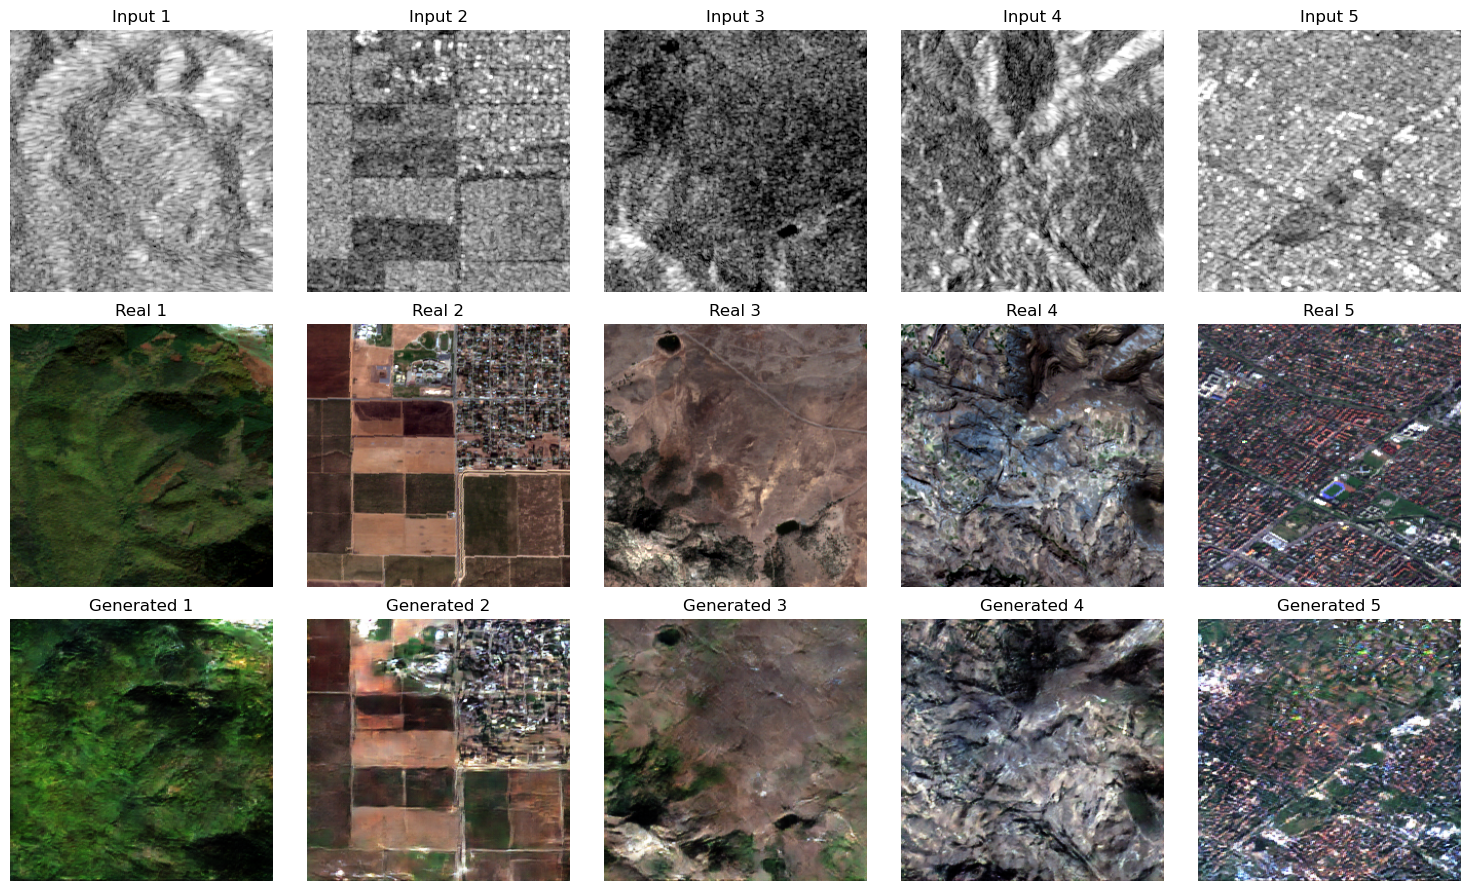

In [20]:
real_images, target_images = next(iter(train_dl))
real_images, target_images = real_images.to(DEVICE), target_images.to(DEVICE)

out = model.get_current_visuals(real_images, target_images)
real_images, target_images, generated_images = out['real'], out['target'], out['fake']

# Plot the outputs
plot_images(5, real_images, target_images, generated_images)

In [21]:
# Function to extract features from Inception v3
def extract_features(images, model):
    # Ensure images are on the right device (CUDA or CPU)
    images = images.cuda() if torch.cuda.is_available() else images
    # Get the features (use the last pooling layer before classification)
    with torch.no_grad():
        features = model(images)
    return features


def calculate_fid(real_features, generated_features):
    # Calculate the mean and covariance of real and generated feature distributions
    mu_real = np.mean(real_features, axis=0)
    mu_gen = np.mean(generated_features, axis=0)
    
    # Calculate covariance matrices
    sigma_real = np.cov(real_features, rowvar=False)
    sigma_gen = np.cov(generated_features, rowvar=False)

    # Compute the Fréchet distance between real and generated distributions
    diff = mu_real - mu_gen
    covmean = sqrtm(sigma_real.dot(sigma_gen))

    # Numerically stable version of sqrtm
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = diff.dot(diff) + np.trace(sigma_real + sigma_gen - 2 * covmean)
    return fid

In [22]:
inception = models.inception_v3(weights='DEFAULT', transform_input=False).eval().to(DEVICE)

# transforms from inception_v3 documentation
transform = v2.Compose([
    v2.Resize(342),
    v2.CenterCrop(299),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_ds = Sentinel(
    root_dir='/home/sainath/Programming/MachineLearning/Test/SentinelDataset',
    split_type="val",
    split_mode='random',
    split_ratio=[0.7, 0.15, 0.15],
    split_file='/home/sainath/Programming/MachineLearning/Test/SentinelDataset/split.json',
    seed=42
)

val_dl = DataLoader(
    val_ds,
    batch_size=32,
    shuffle=True,
    num_workers=4
)

# Create model
model = Pix2Pix(
    c_in=3,
    c_out=3,
    is_train=False,
    use_upsampling=False,
    mode="nearest",
).to(DEVICE).eval()

gen_checkpoint = Path("./Pix2Pix_models/final_pix2pix_gen.pth")

if not gen_checkpoint.exists():
    raise FileNotFoundError(f"Generator checkpoint file not found: {gen_checkpoint}")

model.load_model(gen_checkpoint, device=DEVICE)

target_features = []
fake_features = []

for real_images, target_images in val_dl:
    real_images, target_images = real_images.to(DEVICE), target_images.to(DEVICE)
    
    # Pix2Pix.generate() gets a scaled tensor ([0,1]) returns a uint8 tensor ([0,255])
    fake_images = model.generate(real_images, is_scaled=True, to_uint8=True) 

    # Get target features
    target_images = (target_images * 255).to(dtype=torch.uint8)
    target_images = transform(target_images)
    target_feats = extract_features(target_images, inception)
    target_features.append(target_feats.cpu().numpy())

    # Get fake features
    fake_images = transform(fake_images)
    fake_feats = extract_features(fake_images, inception)
    fake_features.append(fake_feats.cpu().numpy())

# Convert lists to numpy arrays
real_features = np.concatenate(target_features, axis=0)
generated_features = np.concatenate(fake_features, axis=0)

# Compute FID score
fid_score = calculate_fid(real_features, generated_features)
print(f"FID Score: {fid_score}")

Total image pairs found: 2400
FID Score: 320.46374652411646


In [ ]:
#trial
from tqdm import tqdm
# Train the model
num_epochs = PARAMS['epochs']
len_batch = len(dataloader)
save_freq = 10
base_path = '/home/sainath/Programming/MachineLearning/Test/Pix2Pix_models'
scaler = GradScaler('cuda'Total image pairs found: 2400
FID Score: 320.46374652411646)

for epoch in range(94, num_epochs):
    total_lossD = 0.0
    total_lossG = 0.0
    total_lossG_GAN = 0.0
    total_lossG_L1 = 0.0
    model.train()

    # Use tqdm to track progress for each epoch
    with tqdm(dataloader, desc=f"Epoch {epoch}/{num_epochs - 1}", unit="batch") as progress_bar:
        for real_images, target_images in progress_bar:
            real_images, target_images = real_images.to(DEVICE), target_images.to(DEVICE)

            # Forward pass with autocast (mixed precision)
            with autocast('cuda'):
                # Forward pass through generator
                fake_images = model.forward(real_images)

                # Compute Discriminator Loss
                lossD = model.step_discriminator(real_images, target_images, fake_images)

            # Backward pass for discriminator with scaled gradients
            scaler.scale(lossD).backward()
            scaler.step(model.disc_optimizer)
            scaler.update()

            # Zero gradients for discriminator
            model.disc_optimizer.zero_grad()

            # Forward pass with autocast for generator
            with autocast('cuda'):
                lossG, G_losses = model.step_generator(real_images, target_images, fake_images)

            # Backward pass for generator with scaled gradients
            scaler.scale(lossG).backward()
            scaler.step(model.gen_optimizer)
            scaler.update()

            # Zero gradients for generator
            model.gen_optimizer.zero_grad()

            # Accumulate losses for logging
            total_lossD += lossD.item()
            total_lossG += G_losses['loss_G']
            total_lossG_GAN += G_losses['loss_G_GAN']
            total_lossG_L1 += G_losses['loss_G_L1']

        # Calculate average losses
        loss_D = total_lossD / len_batch
        loss_G = total_lossG / len_batch
        loss_G_GAN = total_lossG_GAN / len_batch
        loss_G_L1 = total_lossG_L1 / len_batch

        # Update tqdm progress bar with current losses
        progress_bar.set_postfix({
            "Loss_D": loss_D,
            "Loss_G": loss_G,
            "Loss_G_GAN": loss_G_GAN,
            "Loss_G_L1": loss_G_L1
        })



    # Log the losses
    print(f"Epoch [{epoch}/{num_epochs-1}] - Loss_D: {loss_D:.4f}, Loss_G: {loss_G:.4f}")
    
    # Save model and optimizer periodically
    if epoch % save_freq == 0:
        gen_path = base_path + f'pix2pix_gen_{epoch}.pth'
        disc_path = base_path + f'pix2pix_disc_{epoch}.pth'
        model.save_model(gen_path=gen_path, disc_path=disc_path)
        model.save_optimizer(gen_opt_path='pix2pix_gen_opt.pth', disc_opt_path='pix2pix_disc_opt.pth')